# Charged Particle in an Electromagnetic Field Using PNN

In [17]:
'''
Essential Modules
'''
import learner as ln
from learner.nn.inn import INN
from learner.nn.pnn import PNN

from learner.integrator.hamiltonian import SV

import numpy as np


# Miscellaneous
from os.path import join
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
'''
Loading Data
'''
def load_data(dataset, base_path = '../data_lorentz/'):
    if dataset in ('train', 'test'):
        data = np.loadtxt(join(base_path, dataset + '.txt'), delimiter = ' ')
        print(f'Successfully Loaded {dataset} data...')
    else:
        raise Exception("Input must be either 'train' or 'test'")
        
    return data

In [22]:
class LFData(ln.Data):
    '''The two-dimensional dynamics of the charged particle in the electromagnetic field 
    governed by the Lorentz force.
    m * x'' = q * (E + x' × B)
    H(v,x)=v^T*v/2+1/(100*sqrt(x1^2+x2^2)), B(v,x)=[[-B_hat(x), -I], [I, 0]]
    B_hat(x)=[[0, -sqrt(x1^2+x2^2)], [sqrt(x1^2+x2^2), 0]]
    (p,x)=(v+A(x),x), A(x)=sqrt(x1^2+x2^2)/3*(-x2,x1)^T
    K(p,x)=(p-A(x))^T*(p-A(x))/2+1/(100*sqrt(x1^2+x2^2))
    v = (v1, v2), x = (x1, x2), X = (v, x)=(v1, v2, x1, x2)
    '''
    def __init__(self, z0, h, train_num, test_num):
        super(LFData, self).__init__()
        self.z0 = z0
        #self.dim = len(z0)
        self.h = h
        self.train_num = train_num
        self.test_num = test_num
        
        self.solver = SV(None, self.dK, iterations=10, order=4, N=max(int(self.h * 1e1), 1))
        self.__init_data()
        
    def dK(self, p, x):
        R = np.linalg.norm(x, axis=-1, keepdims=True)
        A = x @ np.array([[0, 1], [-1, 0]]) * (R / 3)
        dA = np.hstack([
                - x[..., :1] * x[..., 1:],
                - x[..., :1] ** 2 - 2 * x[..., 1:] ** 2,
                2 * x[..., :1] ** 2 + x[..., 1:] ** 2,
                x[..., :1] * x[..., 1:]
                ]) / (R * 3)
        dA = dA.reshape([-1, 2, 2])
        dphi = x / (- 100 * R ** 3)
        dp = p - A
        dx = dphi - (np.expand_dims(dp, axis=-2) @ dA).squeeze()
        return dp, dx
    
    def generate_flow(self, z0, h, num):
        z0 = np.array(z0)
        # (v,x) to (p,x)
        v, x = z0[:2], z0[2:]
        p = v + np.array([-x[1], x[0]]) * (np.linalg.norm(x) / 3)
        # solve
        flow = self.solver.flow(np.hstack((p, x)), h, num)
        # (p,x) to (v,x)
        p, x = flow[..., :2], flow[..., 2:]
        v = p - x @ np.array([[0, 1], [-1, 0]]) * (np.linalg.norm(x, axis=-1, keepdims=True) / 3)
        return np.hstack((v, x))
    
    def __init_data(self):
        train_flow = self.generate_flow(self.z0, self.h, self.train_num)
        test_flow = self.generate_flow(train_flow[-1], self.h, self.test_num)
        self.X_train, self.y_train = train_flow[:-1], train_flow[1:]
        self.X_test, self.y_test = test_flow[:-1], test_flow[1:]
        
'''
Utilities
'''
def plot1(data, net, steps, text = 'Positional Predictions', savefig = False):
    if isinstance(net, ln.nn.HNN):
        #flow_true = data.solver.flow(data.X_test_np[0][:-1], data.h, steps)
        flow_true = data.y_test[:-1]
        flow_pred = net.predict(data.X_test[0][:-1], data.h, steps, keepinitx=True, returnnp=True)
    else:
        #flow_true = data.solver.flow(data.X_test_np[0], data.h, steps)
        flow_true = data.y_test
        flow_pred = net.predict(data.X_test[0], steps, keepinitx=True, returnnp=True)
    
    plt.plot(flow_true[:, 2], flow_true[:, 3], 'b-', label='Ground truth', zorder=0, linewidth = 4)
    plt.plot(flow_pred[:, 2], flow_pred[:, 3], 'r-', label='Predicted flow', zorder=1, linewidth = 2)
    plt.plot(data.X_train_np[:, 2], data.X_train_np[:, 3], 'k.', label='Learnt data', zorder=2, linewidth = 2)
    plt.xlabel(f'$x_1$')
    plt.ylabel(f'$x_2$')
    plt.title(text)
    plt.legend()
    plt.axis('square')
    
    if savefig:
        plt.savefig(text + '.pdf')
    
def plot2(data, net, steps, text = 'Positional Predictions', savefig = False):
    def predict(net, x, step):
        import torch
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=net.dtype, device=net.device)
        pred = [x]
        for _ in range(step):
            pred.append(net(pred[-1]))
        return torch.stack(pred).cpu().detach().numpy()
    flow_testtrue = data.generate_flow(data.X_test_np[0], data.h, steps)
    if isinstance(net, ln.nn.INN):
        flow_testpred = predict(net, data.X_test[0], steps)
    else:
        flow_testpred = net.predict(data.X_test[0], steps, keepinitx=True, returnnp=True)
    
    print('Start testing point at:', flow_testtrue[0, 2:4])
    print('Prediction start point at:', flow_testpred[0, 2:4])
    
    plt.figure(figsize=[6.4 * 1, 5.5 * 4])
    
    plt.subplot(411)
    plt.plot(flow_testtrue[:, 2], flow_testtrue[:, 3], 'b-', label='Ground Truth', zorder = 0, linewidth = 3)
    plt.plot(flow_testpred[:, 2], flow_testpred[:, 3], 'r-', label='PNN Predicted', zorder = 1, linewidth = 2)
    plt.plot(data.X_train_np[:, 2], data.X_train_np[:, 3], 'k--', label='Learnt data', zorder=2, linewidth = 2)
    plt.xlabel(r'$x_1$', fontsize=13)
    plt.ylabel(r'$x_2$', fontsize=13)
    plt.title(text)
    plt.legend(fontsize=13)
    plt.axis('equal')
    plt.subplots_adjust(right=1.2)
    #plt.tight_layout()
    
    plt.subplot(412)
    plt.plot(np.arange(steps+1), flow_testtrue[:, 2], color='b', label='Ground Truth')
    plt.plot(np.arange(steps+1), flow_testpred[:, 2], color='r', label='PNN Predicted')
    plt.xlabel(r'Step', fontsize=13)
    plt.ylabel(r'$x_1$', fontsize=13)
    plt.title(f'$x_1$ v.s. Time Steps')
    plt.legend(fontsize=13)
    
    plt.subplot(413)
    plt.plot(np.arange(steps+1), flow_testtrue[:, 3], color='b', label='Ground Truth')
    plt.plot(np.arange(steps+1), flow_testpred[:, 3], color='r', label='PNN Predicted')
    plt.xlabel(r'Step', fontsize=13)
    plt.ylabel(r'$x_2$', fontsize=13)
    plt.title(f'$x_2$ v.s. Time Steps')
    plt.legend(fontsize=13)
    
    plt.subplot(414)
    # Calculate the MSE w.r.t. time t for the predicted results (for the test predictions)
    def MSE(y_pred, y_true):
        diff = y_pred - y_true
        if 1 == y_pred.ndim:
            return np.mean(diff ** 2)
        elif 2 == y_pred.ndim:
            return np.mean(np.sum(diff ** 2, axis = -1))
    
    num_test = len(flow_testtrue)
    MSE_losses = [MSE(flow_testpred[:i+1], flow_testtrue[:i+1]) for i in range(num_test)]
    plt.plot(np.arange(num_test), MSE_losses)
    plt.title('Predicted MSE Loss v.s. Time')
    
    if savefig:
        plt.savefig('LF.pdf')
        
    np.save('PNNloss', np.array(MSE_losses))
    return MSE_losses
    
def init_sympnet(data_dim, net_type, num_layers, width):
    '''
    Initialize the Symplectic Network: LA, G, or HNN
    
    input
        - data_dim  : 
        - net_type  : LA, G or HNN
        - num_layers: 
        - width     : Number of sublayers for LA;
                      Network Width for G and HNN
        *- activation: 'sigmoid' for LA and G
                      'tanh' for HNN
                      
    output 
        - net       :
        - criterion : None for HNN; 'MSE' otherwise
    '''
    criterion = 'MSE'
    if 'LA' == net_type:
        net = ln.nn.LASympNet(data_dim, num_layers, width, 'sigmoid')
    elif 'G' == net_type:
        net = ln.nn.GSympNet(data_dim, num_layers, width, 'sigmoid')
    elif 'HNN' == net_type:
        net = ln.nn.HNN(data_dim, num_layers, width, 'tanh')
        criterion = None
    return net, criterion

In [ ]:
class LData(ln.Data):
    '''
    Alternative way to construct Data for Learning the Lorentz system
    by providing the exact train and test data
    '''
    def __init__(self, train_data, test_data, device = 'cpu'):
        super(LData,self).__init__()
        x_train, y_train = train_data
        x_test, y_test = test_data
        
        self.X_train = x_train
        self.y_train = y_train
        self.X_test = x_test
        self.y_test = y_test
        
        self.__device = device
        self.__dtype = 'float'

In [3]:
'''
Prepare Data 
###### 
Reference: https://github.com/jpzxshi/pnn
'''

#data_train = load_data('train')
#data_test = load_data('test')

DIM = 4
X0 = np.array([1,0.5,0.5,1])
h = 0.1
train_num = 1500
test_num = 300

data = LFData(X0, h, train_num, test_num)

In [4]:
data.X_train.shape

(1500, 4)

In [5]:
data.X_test.shape

(300, 4)

## Problem Step UP
Poission Neural Network primarily consists of 3 parts
1. Coordinate Transformation $\theta$ (Invertible Neural Network)
2. Extended Symplectic Map $\Phi$
3. The Inverse of the Coordinate Transformation $\theta ^{-1}$

Where the `SympNet` is used to learn the local (piecewise) Hamiltonian (Darboux-Lie Theorem) 

In [19]:
'''
Initialize Invertible Neural Network
'''
inn_volume_preserving = True
inn_layers = 10
inn_sublayers = 3
inn_subwidth = 25
inn_activation = 'sigmoid'

inn = INN(data.dim, data.dim//2, inn_layers, inn_sublayers,\
               inn_subwidth, inn_activation, volume_preserving = inn_volume_preserving)

'''
Initialize SympNet
'''
net_type = 'LA' # or 'G'
num_layers = 3
width = 2

sympnet, criterion = init_sympnet(data.dim, net_type, num_layers, width)

'''
Initialize Poisson Neural Network
'''
testpnn = PNN(inn, sympnet)

'''
Hyperparams for Optimizers
'''
lr = 1e-3
num_iters = 5000
print_every = 200

args = {
    'data': data,
    'net': testpnn,
    'criterion': criterion,
    'optimizer': 'adam_lbfgs',
    'lr': lr,
    'iterations': num_iters,
    'batch_size':None,
    'print_every': print_every,
    'save': True,
    'callback': None,
    'dtype' : 'float',
    'device' : 'cpu'
}

In [20]:
'''
Start Training
'''
ln.Brain.Init(**args)
ln.Brain.Run()
ln.Brain.Restore()
ln.Brain.Output()

Training...
0        Train loss: 0.007432949263602495     Test loss: 0.007426569238305092     
200      Train loss: 0.0008880940149538219    Test loss: 0.0008893779013305902    
400      Train loss: 0.0005318510811775923    Test loss: 0.0005323148798197508    
600      Train loss: 0.0005152362864464521    Test loss: 0.0005155705148354173    
800      Train loss: 0.00046439041034318507   Test loss: 0.00046452548122033477   
1000     Train loss: 0.0003320445539429784    Test loss: 0.00033114521647803485   
1200     Train loss: 0.00019148610590491444   Test loss: 0.00019084851373918355   
1400     Train loss: 0.00015042818267829716   Test loss: 0.00015046131738927215   
1600     Train loss: 0.00012349705502856523   Test loss: 0.00012377368693705648   
1800     Train loss: 9.651030268287286e-05    Test loss: 9.69359534792602e-05     
2000     Train loss: 7.447287498507649e-05    Test loss: 7.50197286834009e-05     
2200     Train loss: 5.9501333453226835e-05   Test loss: 6.013367237756029e

Start testing point at: [1.09529054 0.52559578]
Prediction start point at: [1.0952905 0.5255958]


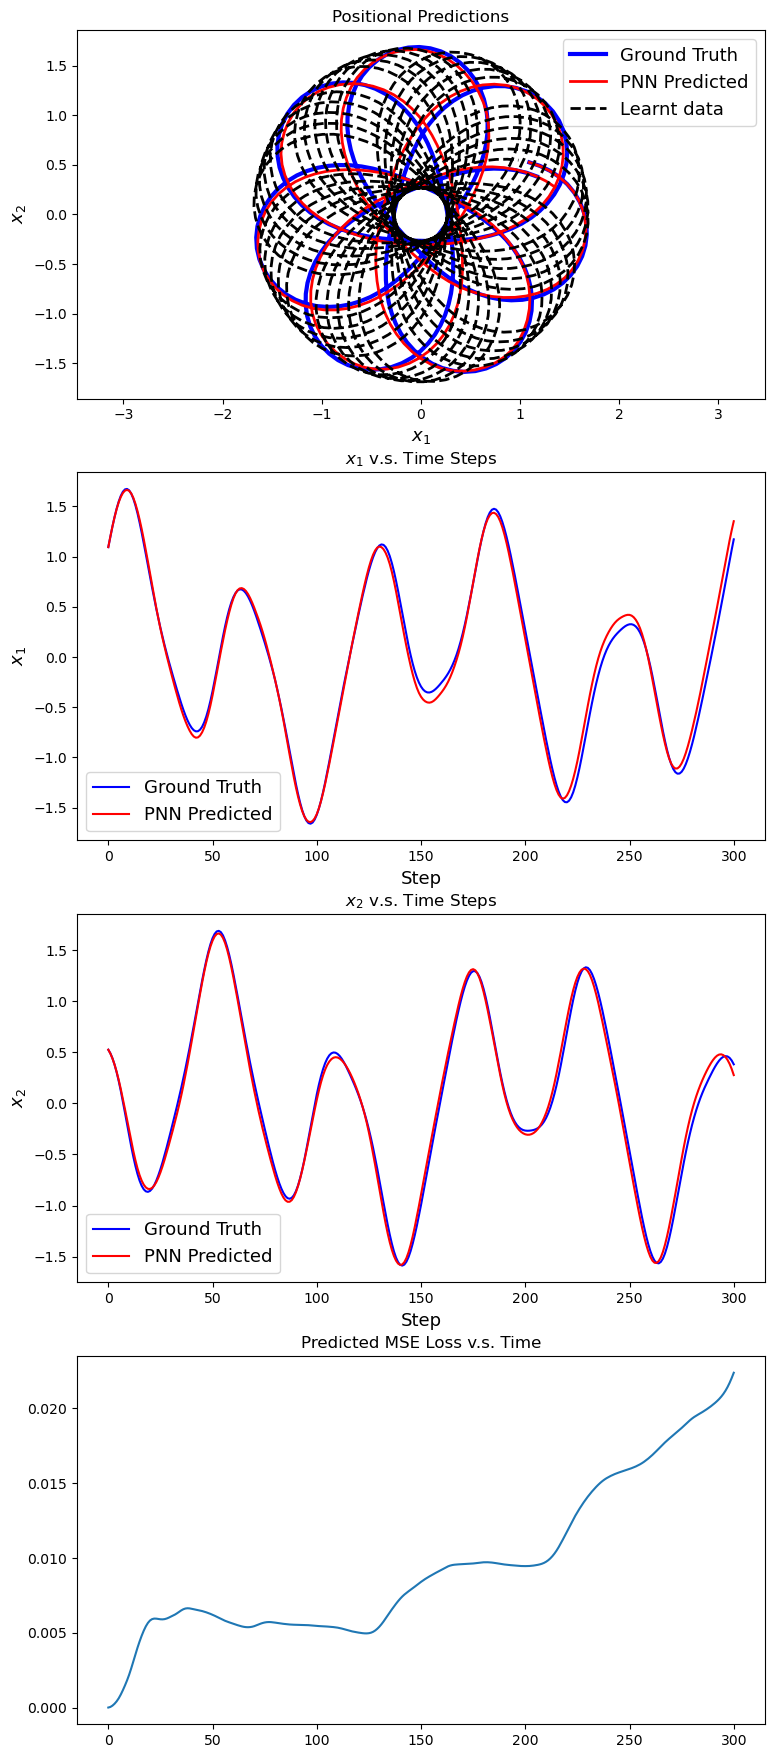

In [23]:
losses = plot2(data, ln.Brain.Best_model(), steps = 300)

-----

## Testing Cells

In [7]:
import torch
bmodel = torch.load('model/model{}.pkl'.format(5001))

In [16]:
bmodel.dtype = torch.float

ValueError: 

In [8]:
plot2(data, bmodel, steps = 300)

TypeError: tensor(): argument 'dtype' must be torch.dtype, not str

In [10]:
data.X_train_np.shape

(1500, 4)

In [12]:
data.X_test_np.shape

(300, 4)

In [13]:
data.X_train_np[0]

array([1. , 0.5, 0.5, 1. ], dtype=float32)

In [11]:
data.X_test_np[0]

array([ 1.0814524 , -0.28615868,  1.0952905 ,  0.5255958 ], dtype=float32)